In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import math
from mpl_toolkits import mplot3d
from pylab import rcParams
rcParams['figure.figsize'] = 10, 15

In [43]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    ax = plt.axes(projection='3d')
    ax.scatter3D(data_1[0,:], data_1[1,:], data_1[1,:], color='#336699', label=label_1)
    ax.scatter3D(data_2[0,:], data_2[1,:], data_2[1,:], color='orangered', label=label_2)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend()
    return ax

### Random Rotation and Translation

In [41]:
theta = math.pi / 3
c, s = np.cos(theta), np.sin(theta)
R_act = np.array(
                    [[c, -s, 0],[s, c, 0], [0, 0, 1]]
                )
t_act = np.array([[-5],[6], [7]])

### Random Point set generation P, Q

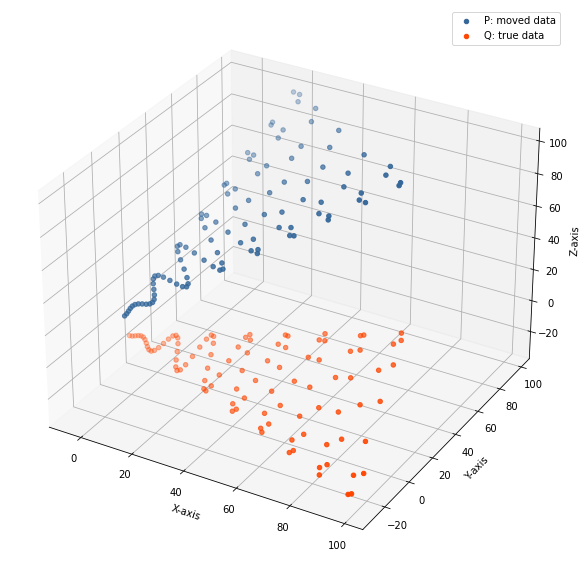

In [44]:
num_points = 100
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.show()

### Brute Force Data Correspondence 

In [45]:
def get_correspondences(P, Q):
    p_size, q_size = P.shape[1], Q.shape[1]
    correspondences = list()
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

In [50]:
def draw_correspondences(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        print(x, y, z)
        print(P[:, i], Q[:, j])
        if not label_added:
            ax.plot(x, y, zs=z, color='grey', label='correpondences')
            break
            label_added = True
        else:
            ax.plot(x, y, zs=z, color='grey')
            break
    ax.legend()

### Mean Centering

In [51]:
def mean_center(S, exclude_indices=[]):
    reduced_data = np.delete(S, exclude_indices, axis=1)
    center = np.array(reduced_data.mean(axis=1)).T
    return center, S - center.reshape(3,1)

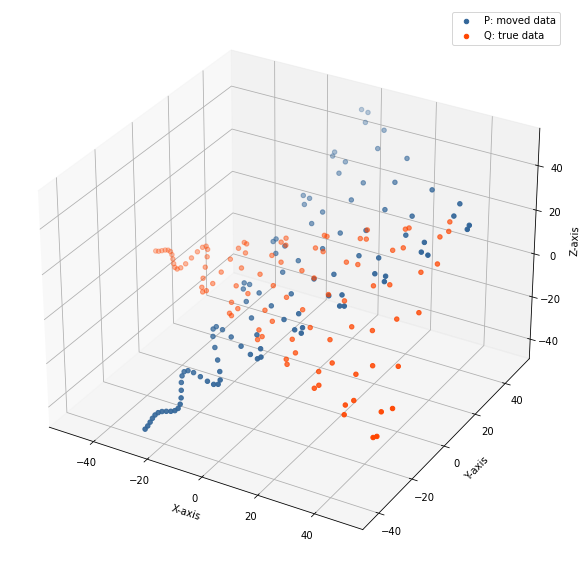

In [52]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

[-25.209621916194916, -14.5] [-42.60289465028914, -9.713347383334492] [-0.03171970130204471, -2.8506670982190054]
[-2.52096219e+01 -4.26028947e+01 -3.17197013e-02] [-14.5         -9.71334738  -2.8506671 ]


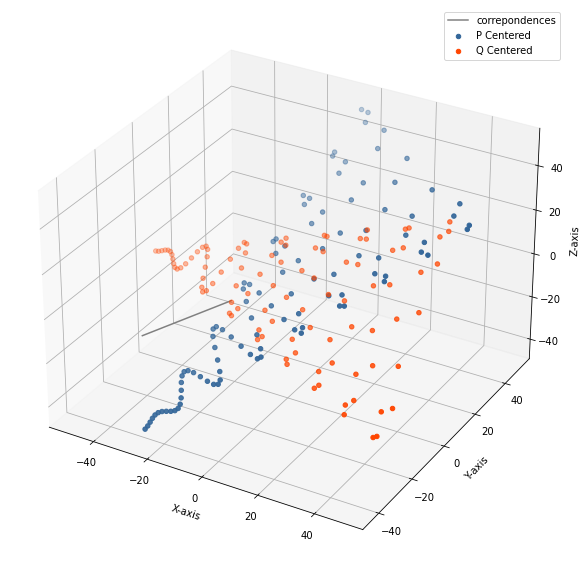

In [53]:
correspondences = get_correspondences(mean_centered_P, mean_centered_Q)
ax = plot_data(mean_centered_P, mean_centered_Q, label_1='P Centered', label_2='Q Centered')
draw_correspondences(mean_centered_P, mean_centered_Q, correspondences, ax)
plt.show()